In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

C:\Users\Rahul\AppData\Local\Temp\ipykernel_14316\4281561738.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
!pip install pydicom

In [3]:
# Importing important libraries
import pandas as pd
import re, random
import pydicom
import numpy as np
import os,cv2
import zipfile
from glob import glob
from PIL import *
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import tensorflow
from tensorflow import keras
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras import Sequential, Model, Input
from keras.initializers import *
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


import warnings
warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.4.3
Numpy version: 1.23.1
Scikit-learn version: 1.1.2
Tensorflow version: 2.11.0
CV version: 4.7.0


# Step 1: Import the data.

In [4]:
# Setting the extracted data directory 
extract_dir =  'D:\\CAPSTONE\\train'
extract_dir2 =  'D:\\CAPSTONE\\test'

In [5]:
# Specifying the path to the zipped dataset files
zip_file_path = 'D:\\CAPSTONE\\stage_2_train_images.zip'
zip_file_path2 = 'D:\\CAPSTONE\\stage_2_test_images.zip'

In [6]:
# Extracting the dataset from the zipped files
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    zip_ref.close()
with zipfile.ZipFile(zip_file_path2, 'r') as zip_ref2:
    zip_ref2.extractall(extract_dir2)
    zip_ref2.close()

# Step 2: Map training and testing images to its classes

# Step 3: Map training and testing images to its annotations

In [7]:
Train_imgs = r"D:\\CAPSTONE\\stage_2_train_images"
Train_labels = r"D:\\CAPSTONE\\stage_2_train_labels.csv"

In [8]:
Test_imgs = r"D:\\CAPSTONE\\stage_2_test_images"

In [9]:
df = pd.read_csv(Train_labels)
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [10]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                           264.0
y                                           152.0
width                                       213.0
height                                      379.0
Target                                          1
Name: 4, dtype: object


In [11]:
patientId = df['patientId'][0]
dcm_file = Train_imgs+'/'+str(patientId)+".dcm"
print(str(dcm_file))
dcm_data = pydicom.dcmread(dcm_file)

D:\\CAPSTONE\\stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


In [12]:
df.shape

(30227, 6)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


# Step 4: Preprocessing and Visualisation of different classes

In [14]:
df[df.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [15]:
## we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia
df[~df.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

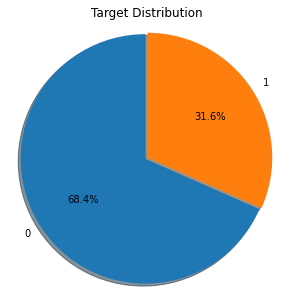

In [16]:
label_count=df['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [17]:
print("Are there Unique Patients In Data Set ?? " ,df['patientId'].is_unique)

Are there Unique Patients In Data Set ??  False


In [18]:
duplicateRows = df[df.duplicated(['patientId'])]
duplicateRows.shape

(3543, 6)

In [19]:
duplicateRows.head(2)

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [20]:
#find exact amount of duplicated cells for 1 entry
df[df.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [21]:
class_labels = pd.read_csv(r"D:\\CAPSTONE\\stage_2_detailed_class_info.csv")
class_labels.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [22]:
class_labels.shape

(30227, 2)

In [23]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [24]:
class_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

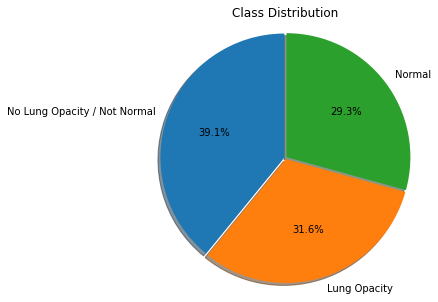

In [25]:
## Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal 
## and the remaining are with Lung Opacity
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [26]:
duplicateClassRows = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRows.shape

(3543, 2)

In [27]:
 #Concatinating the two dataset - 'df' and 'class_labels':
train_data = pd.concat([df, class_labels['class']], axis = 1)

train_data.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


Text(0.5, 1.0, 'Class and Target  Distrubution')

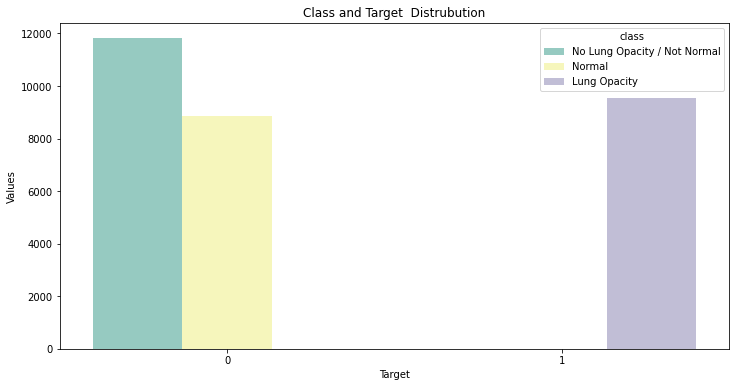

In [28]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = train_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distrubution')

## it shows that class distrubution grouped by Target 
## Target 0 has only Normal or No Lung Opacity class
## Target 1 has only Lung Opacity class

In [29]:
## Analysing the dicom image
import matplotlib.patches as patches
import math

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = Train_imgs+'/{}.dcm'.format(patientImage)
        data_row_img_data = pydicom.dcmread(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = pydicom.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

# Step 5: Display images with bounding box

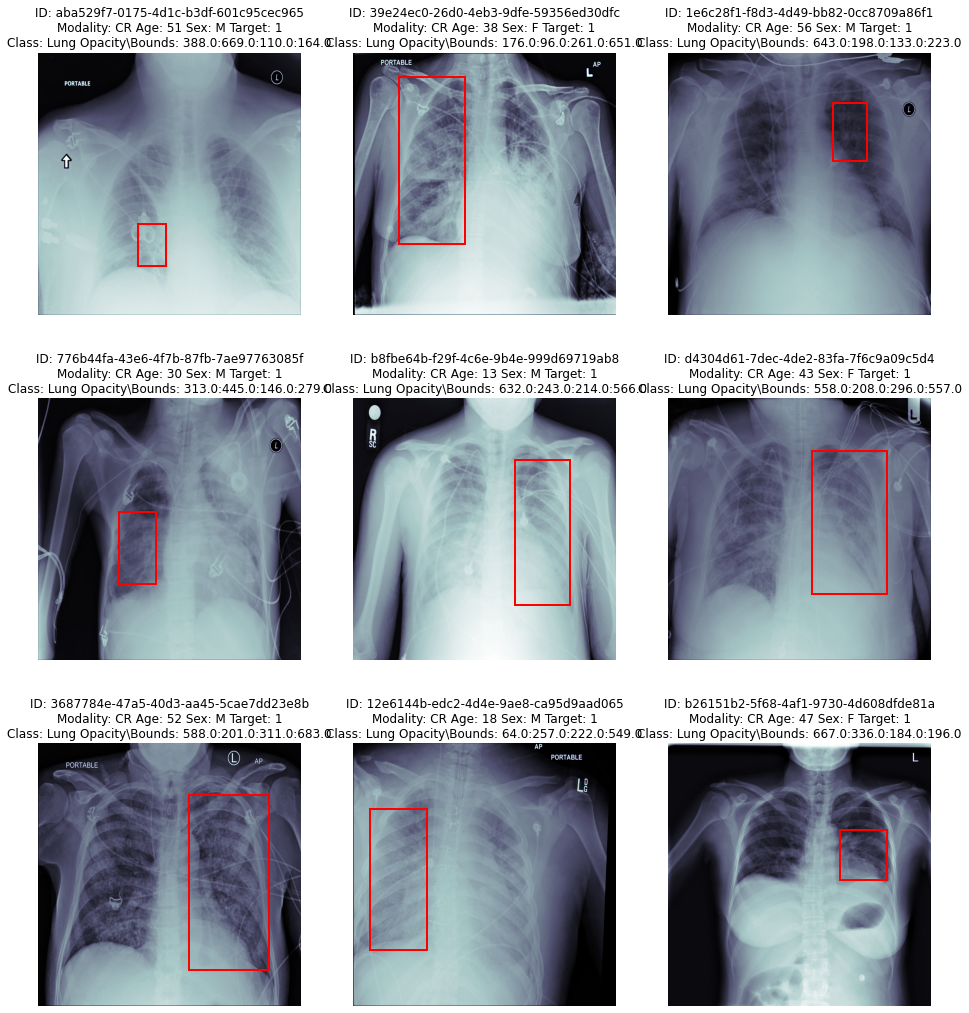

In [30]:
inspectImages(train_data[train_data['Target']==1].sample(9))

In [31]:
## DCIM image contain the meta data along with it, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = Train_imgs+'/{}.dcm'.format(rowData.patientId)
    dcm_data = pydicom.dcmread(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [32]:
train_data['sex'], train_data['age'] = zip(*train_data.apply(readDCIMData, axis=1))

In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


In [34]:
train_data['age'] = train_data.age.astype(int)

In [35]:
train_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,30227,2,M,17216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,30227.0,NaN,NaN,NaN,46.797764,16.89294,1.0,34.0,49.0,59.0,155.0


In [36]:
train_data.sex.value_counts()

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

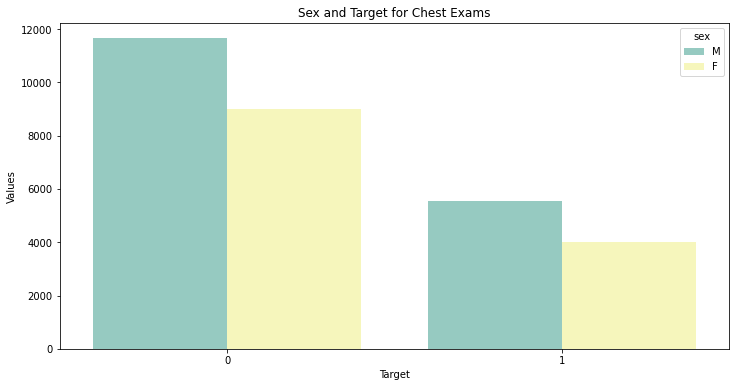

In [37]:
## Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = train_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

## the number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest Exams')

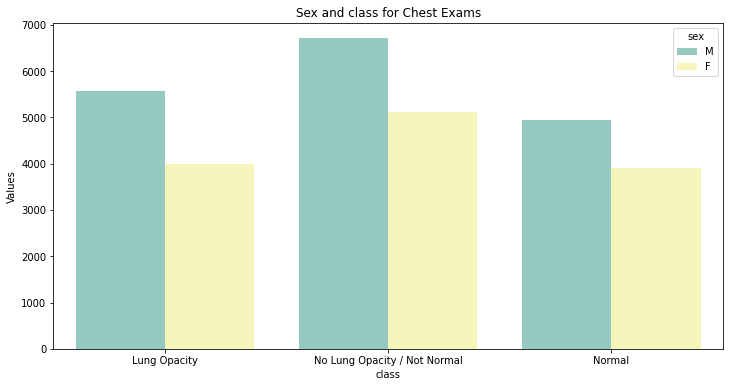

In [38]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = train_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

<AxesSubplot:xlabel='age', ylabel='Density'>

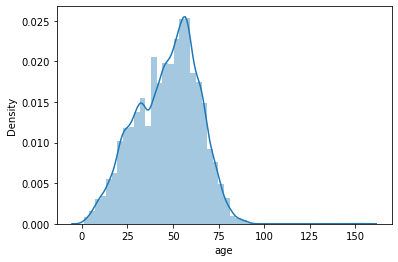

In [39]:
sns.distplot(train_data.age)

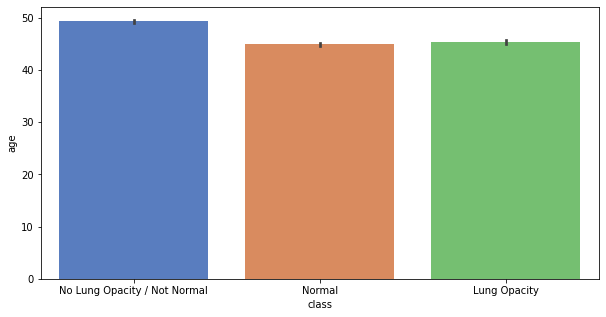

In [40]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=train_data, palette='muted')

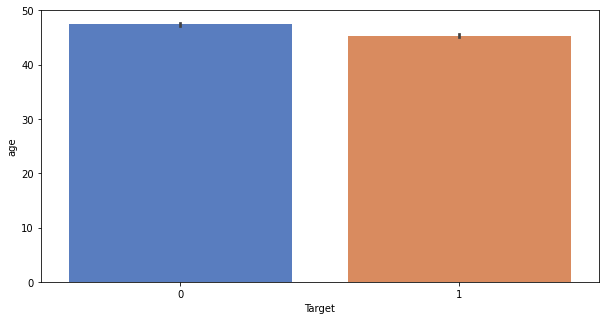

In [41]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=train_data, palette='muted')

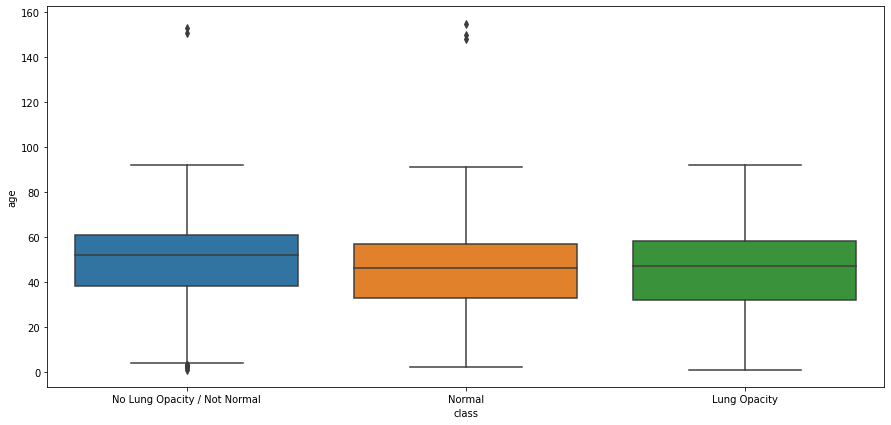

In [42]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= train_data)
plt.show()

There sem to be a few outliers, which we canconsider for tuning in the second stage for now, we are continuing with the current set only!

Distribution of `Age`: Overall and Target = 1


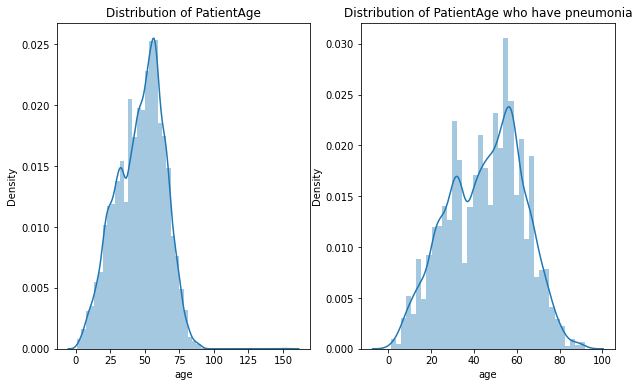

In [43]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(train_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(train_data.loc[train_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

## Overall Distrubution of Age looks normal with very little skewness
## Distubution of Patients afe who have penuomonia are a left skewed

<AxesSubplot:>

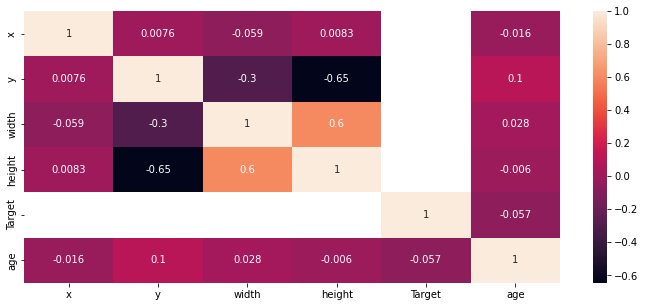

In [44]:
corr = train_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

# Step 6: Design, train and test basic CNN models for classification.

Model building begins now!

In [45]:
## Just taking a few samples from the dataset
sample_traindata = train_data.groupby('class', group_keys=False).apply(lambda x: x.sample(2000))

In [46]:
## Checking the training data set with class distbution 
sample_traindata["class"].value_counts()

Lung Opacity                    2000
No Lung Opacity / Not Normal    2000
Normal                          2000
Name: class, dtype: int64

In [47]:
sample_traindata.shape

(6000, 9)

In [48]:
sample_traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 2568 to 845
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  6000 non-null   object 
 1   x          2000 non-null   float64
 2   y          2000 non-null   float64
 3   width      2000 non-null   float64
 4   height     2000 non-null   float64
 5   Target     6000 non-null   int64  
 6   class      6000 non-null   object 
 7   sex        6000 non-null   object 
 8   age        6000 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(3)
memory usage: 445.3+ KB


In [49]:
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = Train_imgs+'/{}.dcm'.format(patientId)
        dcm_data = pydicom.dcmread(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes with it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [50]:
## Reading the images into numpy array

images,labels = populateImage(sample_traindata)

In [51]:
images.shape , labels.shape

((6000, 128, 128, 3), (6000,))

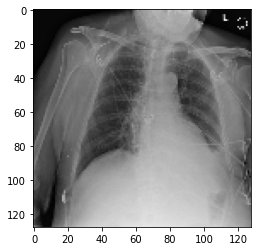

In [52]:
plt.imshow(images[50])

In [53]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import RMSprop
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [54]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [55]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [57]:
## CNN Model without transfer learning , we start with 32 filters with 5,5 kernal and no padding , then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(learning_rate =0.001, rho=0.9, epsilon=1e-08)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [58]:
import time
t1 = time.perf_counter()

### Your code goes here ###
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [59]:
## Training for 10 epocs with batch size of 30
t1 = time.perf_counter()
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 10, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

Epoch 1/10
140/140 [==============================] - 325s 2s/step - loss: 1.9374 - accuracy: 0.3586 - val_loss: 1.0916 - val_accuracy: 0.3633
Epoch 2/10
140/140 [==============================] - 307s 2s/step - loss: 1.0841 - accuracy: 0.4060 - val_loss: 1.0695 - val_accuracy: 0.3933
Epoch 3/10
140/140 [==============================] - 297s 2s/step - loss: 1.0641 - accuracy: 0.4438 - val_loss: 1.0553 - val_accuracy: 0.4433
Epoch 4/10
140/140 [==============================] - 296s 2s/step - loss: 1.0329 - accuracy: 0.4645 - val_loss: 1.0507 - val_accuracy: 0.4722
Epoch 5/10
140/140 [==============================] - 295s 2s/step - loss: 1.0114 - accuracy: 0.4905 - val_loss: 1.0407 - val_accuracy: 0.4211
Epoch 6/10
140/140 [==============================] - 296s 2s/step - loss: 1.0036 - accuracy: 0.4867 - val_loss: 1.0110 - val_accuracy: 0.4756
Epoch 7/10
140/140 [==============================] - 294s 2s/step - loss: 0.9958 - accuracy: 0.5145 - val_loss: 1.0215 - val_accuracy: 0.4522

In [60]:
# I am not sure, but still I hope with epochs increasing it might provide better accuracy, trying now with 30 epochs
## Training for 30 epocs with batch size of 30
t1 = time.perf_counter()
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 30, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

Epoch 1/30
140/140 [==============================] - 294s 2s/step - loss: 0.9952 - accuracy: 0.5105 - val_loss: 1.0100 - val_accuracy: 0.4678
Epoch 2/30
140/140 [==============================] - 298s 2s/step - loss: 0.9703 - accuracy: 0.5283 - val_loss: 1.0361 - val_accuracy: 0.4300
Epoch 3/30
140/140 [==============================] - 296s 2s/step - loss: 0.9636 - accuracy: 0.5286 - val_loss: 0.9832 - val_accuracy: 0.4889
Epoch 4/30
140/140 [==============================] - 298s 2s/step - loss: 0.9615 - accuracy: 0.5236 - val_loss: 1.0129 - val_accuracy: 0.4722
Epoch 5/30
140/140 [==============================] - 296s 2s/step - loss: 0.9532 - accuracy: 0.5283 - val_loss: 1.0106 - val_accuracy: 0.4556
Epoch 6/30
140/140 [==============================] - 296s 2s/step - loss: 0.9542 - accuracy: 0.5443 - val_loss: 0.9909 - val_accuracy: 0.4878
Epoch 7/30
140/140 [==============================] - 295s 2s/step - loss: 0.9402 - accuracy: 0.5348 - val_loss: 0.9783 - val_accuracy: 0.4822

In [61]:
## evaluating the accuracy
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

29/29 [==============================] - 14s 463ms/step - loss: 0.9169 - accuracy: 0.5756
Test loss: 0.916939377784729
Test accuracy: 0.5755555629730225


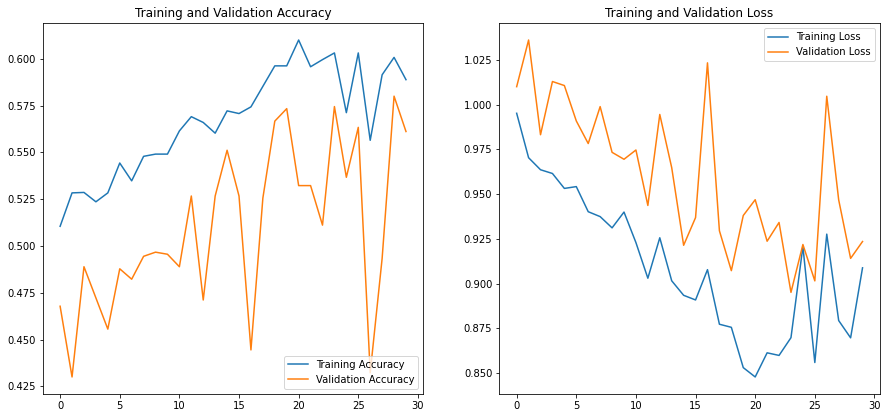

In [62]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy gets better in the later epochs, this could be because we have only taken all images for processing.

In [63]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

29/29 [==============================] - 13s 452ms/step


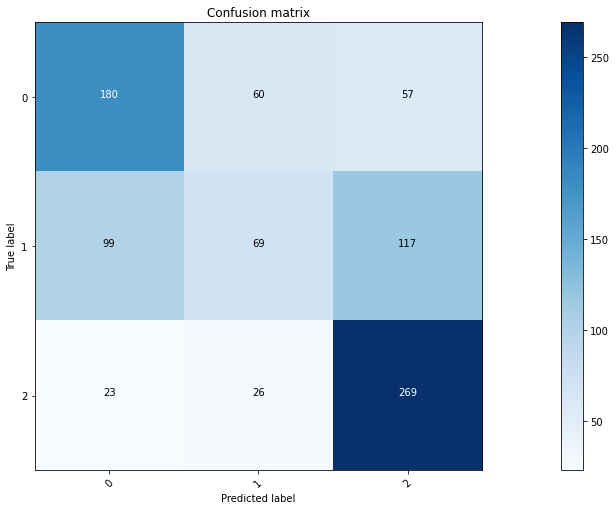

In [64]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal

In [65]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

29/29 [==============================] - 13s 459ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.58881,0.575556,0.445161,0.242105,0.313636,285


In [66]:
# Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

**CNN with Tranfer learning using VGG16**

In [67]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

58889256/58889256 [==============================] - 10s 0us/step


In [68]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu')
dropout_layer_1 = layers.Dropout(0.3)
dense_layer_2 = layers.Dense(50, activation='relu')
dropout_layer_2 = layers.Dropout(0.3)
dense_layer_3 = layers.Dense(20, activation='relu')
dropout_layer_3 = layers.Dropout(0.3)
prediction_layer = layers.Dense(3, activation='softmax')

cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    dense_layer_3,
    dropout_layer_3,
    prediction_layer
])

In [69]:
cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#Training the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))


Epoch 1/30
132/132 [==============================] - 315s 2s/step - loss: 1.0950 - accuracy: 0.4369 - val_loss: 0.5750 - val_accuracy: 0.5678
Epoch 2/30
132/132 [==============================] - 309s 2s/step - loss: 0.6235 - accuracy: 0.4631 - val_loss: 0.5841 - val_accuracy: 0.5500
Epoch 3/30
132/132 [==============================] - 317s 2s/step - loss: 0.5896 - accuracy: 0.5002 - val_loss: 0.5518 - val_accuracy: 0.5378
Epoch 4/30
132/132 [==============================] - 309s 2s/step - loss: 0.5700 - accuracy: 0.5126 - val_loss: 0.5494 - val_accuracy: 0.5711
Epoch 5/30
132/132 [==============================] - 313s 2s/step - loss: 0.5460 - accuracy: 0.5431 - val_loss: 0.5261 - val_accuracy: 0.5511
Epoch 6/30
132/132 [==============================] - 305s 2s/step - loss: 0.5238 - accuracy: 0.5645 - val_loss: 0.5106 - val_accuracy: 0.5622
Epoch 7/30
132/132 [==============================] - 305s 2s/step - loss: 0.5117 - accuracy: 0.5840 - val_loss: 0.5377 - val_accuracy: 0.6278

In [64]:
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

In [71]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

29/29 [==============================] - 54s 2s/step - loss: 0.7130 - accuracy: 0.3344
Test loss: 0.7130246758460999
Test accuracy: 0.33444443345069885


In [72]:
actual_train_accuracy = history.history['accuracy'][-1]
actual_val_accuracy = history.history['val_accuracy'][-1]

print('Actual Training Accuracy:', actual_train_accuracy)
print('Actual Validation Accuracy:', actual_val_accuracy)

Actual Training Accuracy: 0.7888095378875732
Actual Validation Accuracy: 0.6088888645172119


In [73]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",history.history['accuracy'][-1],fcl_accuracy)])

In [74]:
resultsDf1.head()

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.58881,0.575556,0.445161,0.242105,0.313636,285.0
0,CNN With VGG16,0.78881,0.334444,NaN,NaN,NaN,NaN


In [75]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score, classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

29/29 [==============================] - 14s 461ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.58881,0.575556,0.445161,0.242105,0.313636,285
0,CNN With VGG16,0.78881,0.334444,0.445161,0.242105,0.313636,285


In [76]:
Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

29/29 [==============================] - 13s 463ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.58881,0.575556,0.445161,0.242105,0.313636,285
0,CNN With VGG16,0.78881,0.334444,0.445161,0.242105,0.313636,285


# CNN with ResNet50

In [78]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras import layers

# Existing layers
resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')  # increased the number of neurons
dense_layer_2 = layers.Dense(128, activation='relu')  # increased the number of neurons
prediction_layer = layers.Dense(3, activation='softmax')

# Additional layers
additional_dense_layer = layers.Dense(64, activation='relu')  # reduced the number of neurons
dropout_layer_1 = layers.Dropout(0.5)  # You can adjust the dropout rate as needed
dropout_layer_2 = layers.Dropout(0.3)  # You can adjust the dropout rate as needed

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,  # Add the dropout layer after the first dense layer
    additional_dense_layer,  # Add the additional dense layer
    dropout_layer_2,  # Add another dropout layer after the additional dense layer
    dense_layer_2,
    prediction_layer
])

94765736/94765736 [==============================] - 26s 0us/step


In [79]:
from tensorflow.keras.callbacks import EarlyStopping
cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [80]:
#Trainign the model
history =cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
132/132 [==============================] - 686s 5s/step - loss: 0.6551 - accuracy: 0.5498 - val_loss: 5.9873 - val_accuracy: 0.4589
Epoch 2/30
132/132 [==============================] - 636s 5s/step - loss: 0.5180 - accuracy: 0.6157 - val_loss: 5.6598 - val_accuracy: 0.5067
Epoch 3/30
132/132 [==============================] - 608s 5s/step - loss: 0.4729 - accuracy: 0.6552 - val_loss: 4.8393 - val_accuracy: 0.4522
Epoch 4/30
132/132 [==============================] - 614s 5s/step - loss: 0.4583 - accuracy: 0.6698 - val_loss: 2.4543 - val_accuracy: 0.3667
Epoch 5/30
132/132 [==============================] - 640s 5s/step - loss: 0.4328 - accuracy: 0.6938 - val_loss: 1.3154 - val_accuracy: 0.6356
Epoch 6/30
132/132 [==============================] - 625s 5s/step - loss: 0.4286 - accuracy: 0.6921 - val_loss: 0.6591 - val_accuracy: 0.6100
Epoch 7/30
132/132 [==============================] - 627s 5s/step - loss: 0.4047 - accuracy: 0.7114 - val_loss: 0.6612 - val_accuracy: 0.5533

In [81]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

29/29 [==============================] - 23s 789ms/step - loss: 0.8537 - accuracy: 0.3300
Test loss: 0.8537001013755798
Test accuracy: 0.33000001311302185


In [82]:
resultsDf2 = pd.concat([resultsDf1, createResultDf("CNN With ResNet50",history.history['accuracy'][-1],fcl_accuracy)])

In [83]:
resultsDf2.head()

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.588810,0.575556,0.445161,0.242105,0.313636,285.0
0,CNN With VGG16,0.788810,0.334444,0.445161,0.242105,0.313636,285.0
0,CNN With ResNet50,0.890714,0.330000,NaN,NaN,NaN,NaN


In [84]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1)

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf2[data+"_"+subData] = reportData[data][subData]

29/29 [==============================] - 14s 469ms/step


29/29 [==============================] - 25s 829ms/step


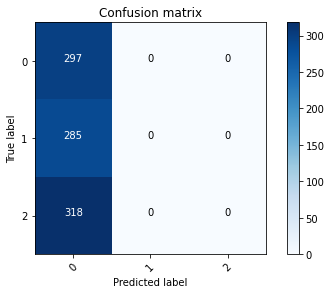

In [85]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(3))

In [86]:
resultsDf2.head()

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.588810,0.575556,0.445161,0.242105,0.313636,285
0,CNN With VGG16,0.788810,0.334444,0.445161,0.242105,0.313636,285
0,CNN With ResNet50,0.890714,0.330000,0.445161,0.242105,0.313636,285


# CNN with Xception

In [87]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers, models

xception_base_model = Xception(include_top=False, weights='imagenet', input_shape=X_train[0].shape)

train_ds = preprocess_input(X_train1)
train_val_df = preprocess_input(X_val1)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(1024, activation='relu')
dropout_layer_1 = layers.Dropout(0.3)
dense_layer_2 = layers.Dense(512, activation='relu')
dropout_layer_2 = layers.Dropout(0.3)
dense_layer_3 = layers.Dense(256, activation='relu')
dropout_layer_3 = layers.Dropout(0.3)
dense_layer_4 = layers.Dense(128, activation='relu')
dropout_layer_4 = layers.Dropout(0.3)
dense_layer_5 = layers.Dense(64, activation='relu')
dropout_layer_5 = layers.Dropout(0.3)
dense_layer_6 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_xception_model = models.Sequential([
    xception_base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    dense_layer_3,
    dropout_layer_3,
    dense_layer_4,
    dropout_layer_4,
    dense_layer_5,
    dropout_layer_5,
    dense_layer_6,
    prediction_layer
])

83683744/83683744 [==============================] - 14s 0us/step


In [88]:
# Compile the model
cnn_xception_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [89]:
# Train the model
history = cnn_xception_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
132/132 [==============================] - 750s 6s/step - loss: 0.6134 - accuracy: 0.4436 - val_loss: 2.5514 - val_accuracy: 0.4789
Epoch 2/30
132/132 [==============================] - 715s 5s/step - loss: 0.4940 - accuracy: 0.6050 - val_loss: 1.3017 - val_accuracy: 0.5156
Epoch 3/30
132/132 [==============================] - 705s 5s/step - loss: 0.4925 - accuracy: 0.6069 - val_loss: 0.7936 - val_accuracy: 0.5611
Epoch 4/30
132/132 [==============================] - 736s 6s/step - loss: 0.4581 - accuracy: 0.6433 - val_loss: 0.8338 - val_accuracy: 0.5722
Epoch 5/30
132/132 [==============================] - 705s 5s/step - loss: 0.4236 - accuracy: 0.6740 - val_loss: 0.6966 - val_accuracy: 0.6056
Epoch 6/30
132/132 [==============================] - 711s 5s/step - loss: 0.4160 - accuracy: 0.6769 - val_loss: 3.6921 - val_accuracy: 0.5200
Epoch 7/30
132/132 [==============================] - 707s 5s/step - loss: 0.4062 - accuracy: 0.7079 - val_loss: 0.5312 - val_accuracy: 0.6478

In [90]:
fcl_loss, fcl_accuracy = cnn_xception_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

29/29 [==============================] - 25s 845ms/step - loss: 1.9993 - accuracy: 0.3733
Test loss: 1.9993435144424438
Test accuracy: 0.3733333349227905


In [91]:
resultsDf3 = pd.concat([resultsDf2, createResultDf("CNN With Xception",history.history['accuracy'][-1],fcl_accuracy)])

In [92]:
resultsDf3.head()

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.588810,0.575556,0.445161,0.242105,0.313636,285.0
0,CNN With VGG16,0.788810,0.334444,0.445161,0.242105,0.313636,285.0
0,CNN With ResNet50,0.890714,0.330000,0.445161,0.242105,0.313636,285.0
0,CNN With Xception,0.874524,0.373333,NaN,NaN,NaN,NaN


In [93]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1)

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf3[data+"_"+subData] = reportData[data][subData]
resultsDf3

29/29 [==============================] - 14s 496ms/step


,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.588810,0.575556,0.0,0.0,0.0,285
0,CNN With VGG16,0.788810,0.334444,0.0,0.0,0.0,285
0,CNN With ResNet50,0.890714,0.330000,0.0,0.0,0.0,285
0,CNN With Xception,0.874524,0.373333,0.0,0.0,0.0,285


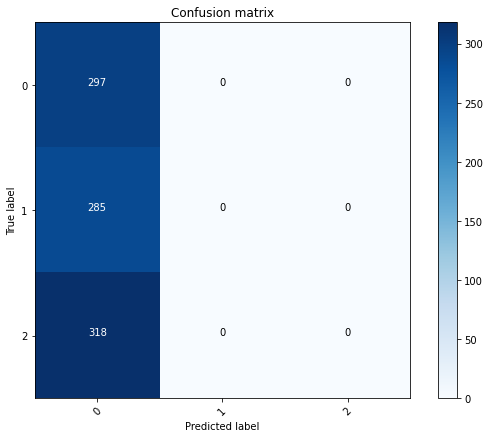

In [94]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Define the function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
class_names = [0, 1, 2]  # Replace with your actual class names
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False)

# Display the plot
plt.show()

In [95]:
resultsDf3.head()

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.588810,0.575556,0.0,0.0,0.0,285
0,CNN With VGG16,0.788810,0.334444,0.0,0.0,0.0,285
0,CNN With ResNet50,0.890714,0.330000,0.0,0.0,0.0,285
0,CNN With Xception,0.874524,0.373333,0.0,0.0,0.0,285


# Based on the table above we are choosing basic CNN Model

In [56]:
labels_1 = pd.read_csv(Train_labels)

In [57]:
## Getting the first 5000 data set for traingin and the next 5000 for validations
train_CombinedData = labels_1[0:5000]
validate_CombinedData = labels_1[5000:10000]

train_CombinedData.fillna(0, inplace=True)
validate_CombinedData.fillna(0, inplace=True)

In [58]:
train_CombinedData.Target.value_counts()

0    2633
1    2367
Name: Target, dtype: int64

In [61]:
from tensorflow.keras.applications.mobilenet import preprocess_input 
from tensorflow.keras.utils import Sequence

BATCH_SIZE = 10

## Image Size to be scaled
IMAGE_SIZE = 224


## Actual Image size 
IMG_WIDTH = 1024
IMG_HEIGHT = 1024


class TrainGenerator(Sequence):

    def __init__(self,  _labels):       
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    
    """
    The contrast of an image is enhanced when various shades in the image becomes more distinct.
    We can do so by darkening the shades of the darker pixels and vice versa. 
    This is equivalent to widening the range of pixel intensities. To have a good contrast, 
    the following histogram characteristics are desirable:

    1) the pixel intensities are uniformly distributed across the full range of values (each intensity value is equally probable), and
    2) the cumulative histogram is increasing linearly across the full intensity range.

    Histogram equalization modifies the distribution of pixel intensities to achieve these characteristics.
    """

    def __doHistogramEqualization(self,img):
        # Pre processing Histogram equalization
        histogram_array = np.bincount(img.flatten(), minlength=256)
        #normalize
        num_pixels = np.sum(histogram_array)
        histogram_array = histogram_array/num_pixels
        #normalized cumulative histogram
        chistogram_array = np.cumsum(histogram_array)
        """
        STEP 2: Pixel mapping lookup table
        """
        transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
        """
        STEP 3: Transformation
        """
        img_list = list(img.flatten())

        # transform pixel values to equalize
        eq_img_list = [transform_map[p] for p in img_list]

        # reshape and write back into img_array
        img = np.reshape(np.asarray(eq_img_list), img.shape)

        return img

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = Train_imgs+'\\{}.dcm'.format(_pid)
            _imgData = pydicom.dcmread(_path)
            img = _imgData.pixel_array 
#             img = np.stack((img,)*3, axis=-1) # Expand grayscale image to contain 3 channels

            # Resize image
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            
            resized_img = self.__doHistogramEqualization(resized_img)
        
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks

In [62]:
trainUNetDataGen = TrainGenerator( train_CombinedData)
validateUNetDataGen = TrainGenerator( validate_CombinedData)

In [63]:
# To show image with mask
def showMaskedImage(_imageSet, _maskSet, _index) :
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    plt.imshow(maskImage[:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


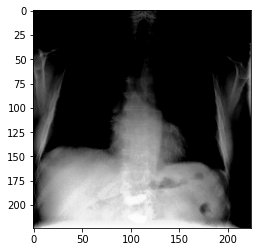

In [64]:
## One of the pre processed image from custom train generotr
imageSet0 = trainUNetDataGen[1][0][1]
plt.imshow(imageSet0)

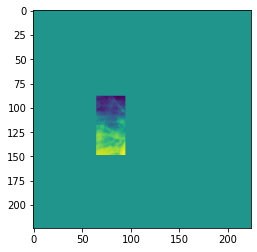

In [65]:
## Masks for the same
imageSet0 = trainUNetDataGen[2][0]
maskSet0 = trainUNetDataGen[2][1]    
showMaskedImage(imageSet0, maskSet0, 5)

# Pickling the models

In [72]:
import pickle

In [138]:
# save the model to disk
filename = r'D:\CAPSTONE\finalized_CNN_model.sav'
pickle.dump(cnn, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\dropout_3
......vars
...layers\global_max_pooling2d
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\max_pooling2d_2
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
........

In [139]:
# save the model to disk
filename = r'D:\CAPSTONE\finalized_cnn_VGG16_model.sav'
pickle.dump(cnn_VGG16_model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...layers\functional
......vars
...layers\functional\layers\conv2d
......vars
.........0
.........1
...layers\functional\layers\conv2d_1
......vars
.........0
.........1
...layers\functional\layers\conv2d_10
......vars
.........0
.........1
...layers\functional\layers\conv2d_11
......vars
.........0
.........1
...layers\functional\layers\conv2d_12
......vars
.........0
.........1
...layers\functional\layers\conv2d_2
......vars
.........0
.........1
...layers\functional\layers\conv2d_3
......vars
.........0
.........1
...layers\functional\layers\conv2d_4
......vars
.........0
.........1
...layers\functiona

In [140]:
# save the model to disk
filename = r'D:\CAPSTONE\finalized_cnn_resnet_model.sav'
pickle.dump(cnn_resnet_model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\functional
......vars
...layers\functional\layers\activation
......vars
...layers\functional\layers\activation_1
......vars
...layers\functional\layers\activation_10
......vars
...layers\functional\layers\activation_11
......vars
...layers\functional\layers\activation_12
......vars
...layers\functional\layers\activation_13
......vars
...layers\functional\layers\activation_14
......vars
...layers\functional\layers\activation_15
......vars
...layers\functional\layers\activation_16
......vars
...layers\functional\layers\activation_17
......vars
...layers\functional\layers\activation_18
......vars
...layers\functional\layers\acti

In [141]:
# save the model to disk
filename = r'D:\CAPSTONE\finalized_cnn_xception_model.sav'
pickle.dump(cnn_xception_model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dense_4
......vars
.........0
.........1
...layers\dense_5
......vars
.........0
.........1
...layers\dense_6
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\dropout_3
......vars
...layers\dropout_4
......vars
...layers\flatten
......vars
...layers\functional
......vars
...layers\functional\layers\activation
......vars
...layers\functional\layers\activation_1
......vars
...layers\functional\layers\activation_10
......vars
...layers\functional\layers\activation_11
......vars
...layers\functional\layers\activation_12
......vars
...layers\functional\layers\activation_13
......vars
...layers\functional\layers\activation_14
......var